In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import DataLoader, Dataset
from efficientnet_pytorch import EfficientNet
import os
from torchvision.io import read_image
import torchvision.transforms as transforms
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Creating Custom DataSet

In [43]:
class CellImageDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.labels = []
        self.image_paths = []
        self.transform = transform
        self.class_to_idx = {}

        for idx, class_name in enumerate(os.listdir(img_dir)):
            self.class_to_idx[class_name] = idx
            class_dir = os.path.join(img_dir, class_name)
            if os.path.isdir(class_dir):
                for img_name in os.listdir(class_dir):
                    img_path = os.path.join(class_dir, img_name)
                    self.labels.append(idx)
                    self.image_paths.append(img_path)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        label = self.labels[idx]
        image = read_image(self.image_paths[idx])
        image = transforms.ToPILImage()(image)  # Convert the tensor image to a PIL Image
        if self.transform:
            image = self.transform(image)
        return image, label


# Adapting EficiNet to the Custom DataSet

In [44]:
class CustomEfficientNet(nn.Module):
    def __init__(self, num_classes):
        super(CustomEfficientNet, self).__init__()
        self.efficient_net = EfficientNet.from_pretrained('efficientnet-b0')
        
        # Get the output dimension of the EfficientNet feature extractor
        efficient_net_output_dim = self.efficient_net._fc.in_features
        self.efficient_net._fc = nn.Identity()  # Remove the final classification layer

        # Define the combined fully connected layer
        self.fc_combined = nn.Linear(efficient_net_output_dim, num_classes)

    def forward(self, images):
        efficient_net_out = self.efficient_net(images)
        efficient_net_out = torch.flatten(efficient_net_out, 1)
        out = self.fc_combined(efficient_net_out)
        return out

In [45]:
def evaluate_model(model, data_loader, criterion):
    model.eval()
    running_loss = 0.0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for images, labels in data_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    
    avg_loss = running_loss / len(data_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    return avg_loss, accuracy, precision, recall, f1, all_labels, all_preds

def plot_confusion_matrix(true_labels, pred_labels, classes):
    cm = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

In [46]:
img_dir = 'partial_sub_images'
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
dataset = CellImageDataset(img_dir, transform=transform)

num_classes = len(dataset.class_to_idx)

model = CustomEfficientNet(num_classes)

# Dividir o dataset em conjuntos de treino e teste
train_set, test_set = train_test_split(dataset, test_size=0.2, random_state=42)

# Criar os dataloaders para os conjuntos de treino e teste
batch_size = 32
train_loader = data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Loaded pretrained weights for efficientnet-b0


# Treinamento do modelo

In [47]:

for epoch in range(10):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1} - Loss: {running_loss/len(train_loader)}")



Epoch 1 - Loss: 1.6840182940165203
Epoch 2 - Loss: 0.9779841502507528
Epoch 3 - Loss: 0.38005704681078595
Epoch 4 - Loss: 0.1916214277346929
Epoch 5 - Loss: 0.09799188375473022
Epoch 6 - Loss: 0.053379105404019356
Epoch 7 - Loss: 0.06359597916404407
Epoch 8 - Loss: 0.020519598076740902
Epoch 9 - Loss: 0.014783282919476429
Epoch 10 - Loss: 0.01032377042186757


# Avaliação do modelo

c:\Python\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Loss: 2.3315
Test Accuracy: 0.1000
Test Precision: 0.1500
Test Recall: 0.1000
Test F1 Score: 0.1200


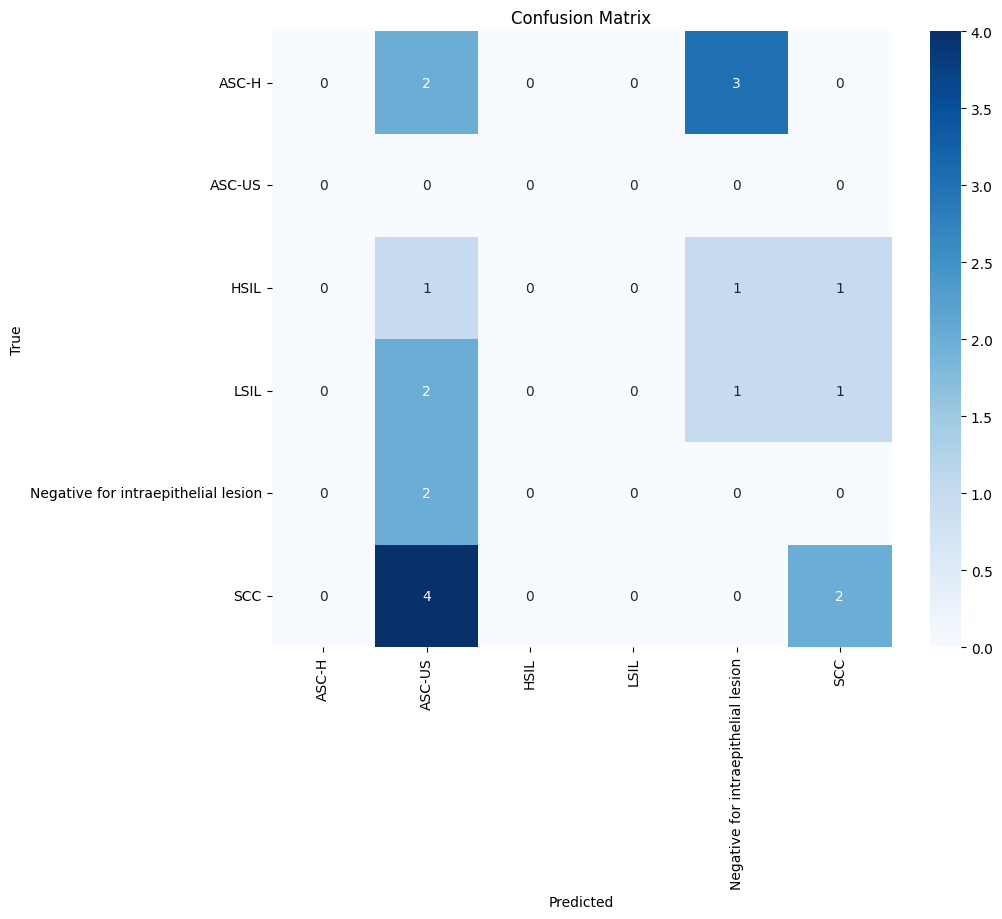

In [48]:
test_loss, test_accuracy, test_precision, test_recall, test_f1, all_labels, all_preds = evaluate_model(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

# Plot da matriz de confusão
plot_confusion_matrix(all_labels, all_preds, list(dataset.class_to_idx.keys()))